<a href="https://colab.research.google.com/github/danielAdama/crop-mapping-classification/blob/main/Crop_mapping_using_fused_optical_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** Is to develop a machine learning approach to make predictions on different crop cultures (e.g Corn, Pea, etc.) which is a multi-class classification task.

In [ ]:
import pandas as pd
import os
import numpy as np
import pathlib
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (22, 10)

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

**Download the Zip file from the url and store locally**

In [ ]:
CM_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00525/data.zip"

BASE_DIR = pathlib.Path().resolve()
DATASET_DIR = BASE_DIR / "datasets"
DATASET_DIR.mkdir(exist_ok=True)

ZIPS_DIR = DATASET_DIR / "zips"
ZIPS_DIR.mkdir(exist_ok=True)

CM_ZIPS_PATH = ZIPS_DIR / "CM-dataset.zip"

# !curl $CM_ZIP_URL -o $CM_ZIPS_PATH

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150M  100  150M    0     0  41.2M      0  0:00:03  0:00:03 --:--:-- 41.2M


**Unzip the file**

In [ ]:
UNZIPS_DIR = DATASET_DIR / "unzips"
UNZIPS_DIR.mkdir(exist_ok=True)
CM_DIR = UNZIPS_DIR / "CM-dataset"
UNZIPS_DIR.mkdir(exist_ok=True)

!unzip -o $CM_ZIPS_PATH -d $CM_DIR

Archive:  /content/datasets/zips/CM-dataset.zip
  inflating: /content/datasets/unzips/CM-dataset/WinnipegDataset.txt  


# 2. Exploratory Data Analysis and Pre-processing

In [ ]:
raw_data = pd.read_csv(os.path.join(CM_DIR, "WinnipegDataset.txt"))
print(raw_data.shape)
print()
print(raw_data.info())
raw_data.head()

(325834, 175)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Columns: 175 entries, label to f174
dtypes: float64(169), int64(6)
memory usage: 435.0 MB
None


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,0.17610,0.16811,0.002613,0.066037,0.025145,0.028249,0.056669,0.037053,0.005979,0.024823,-12.564,-23.436,-13.858,-18.209,-11.5560,-17.934,1.2944,-10.873,-9.5783,-0.274930,6.6524,6.3775,0.54823,0.044843,0.40693,0.14944,0.69136,0.15920,-1.8727,-0.78500,-1.9895,-2.9965,-1.7738,-1.7326,0.071334,0.025359,0.004391,0.66368,0.70484,42.797,0.46779,0.19589,0.23705,0.099269,0.061549,0.17374,-11.5560,-15.740,-23.436,0.18156,0.11893,0.003407,0.057758,0.019568,0.017713,0.058723,0.019425,0.004282,0.016069,0.009,0.057,0.048,0.165,0.369,0.76978,7.6875,1.18750,0.50488,0.61842,0.52508,0.085714,0.73239,0.50279,0.38202,2.2364,-0.48649,17.28,0.54930,0.128250,7.38,3.4375,22.667,8.22220,0.27512,13.44400,3.00000,2.1972,0.11111,0.452700,7.7778,17.28400,0.27566,24.55600,3.66670,2.0432,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,0.18909,0.18203,0.006412,0.078576,0.027181,0.034402,0.066831,0.043155,0.005979,0.027797,-11.559,-22.730,-12.844,-17.334,-10.5000,-17.095,1.2853,-11.172,-9.8863,-0.239200,6.8340,6.5948,0.54939,0.041949,0.40866,0.14534,0.70110,0.15357,-1.9547,-0.75344,-1.9783,-2.9398,-1.8280,-1.7547,0.090777,0.031174,0.005176,0.65128,0.71519,42.706,0.46579,0.18549,0.24940,0.099319,0.057024,0.16287,-10.5000,-14.859,-22.730,0.20112,0.12981,0.002202,0.071813,0.023410,0.019954,0.072635,0.023165,0.004282,0.018801,0.001,0.044,0.037,0.103,0.290,0.77370,7.8378,1.18920,0.42041,0.59780,0.45889,0.086420,0.73653,0.42498,0.47583,2.8155,-0.40136,16.24,0.47143,0.099454,4.24,2.7838,18.556,0.46914,0.60000,1.33330,0.88889,1.5230,0.23457,-0.132450,3.8889,0.32099,0.72222,0.55556,0.55556,1.2730,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,0.19562,0.19066,0.010325,0.027212,0.086472,0.039597,0.072656,0.047041,0.005979,0.029540,-11.040,-22.566,-12.458,

# 3. Target Exploration (label)

**Labels based on index**

1. Corn
2. Pea
3. Canola
4. Soy
5. Oat
6. Wheat
7. Broadleaf

In [ ]:
raw_data.label.value_counts().sort_index()

1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
Name: label, dtype: int64

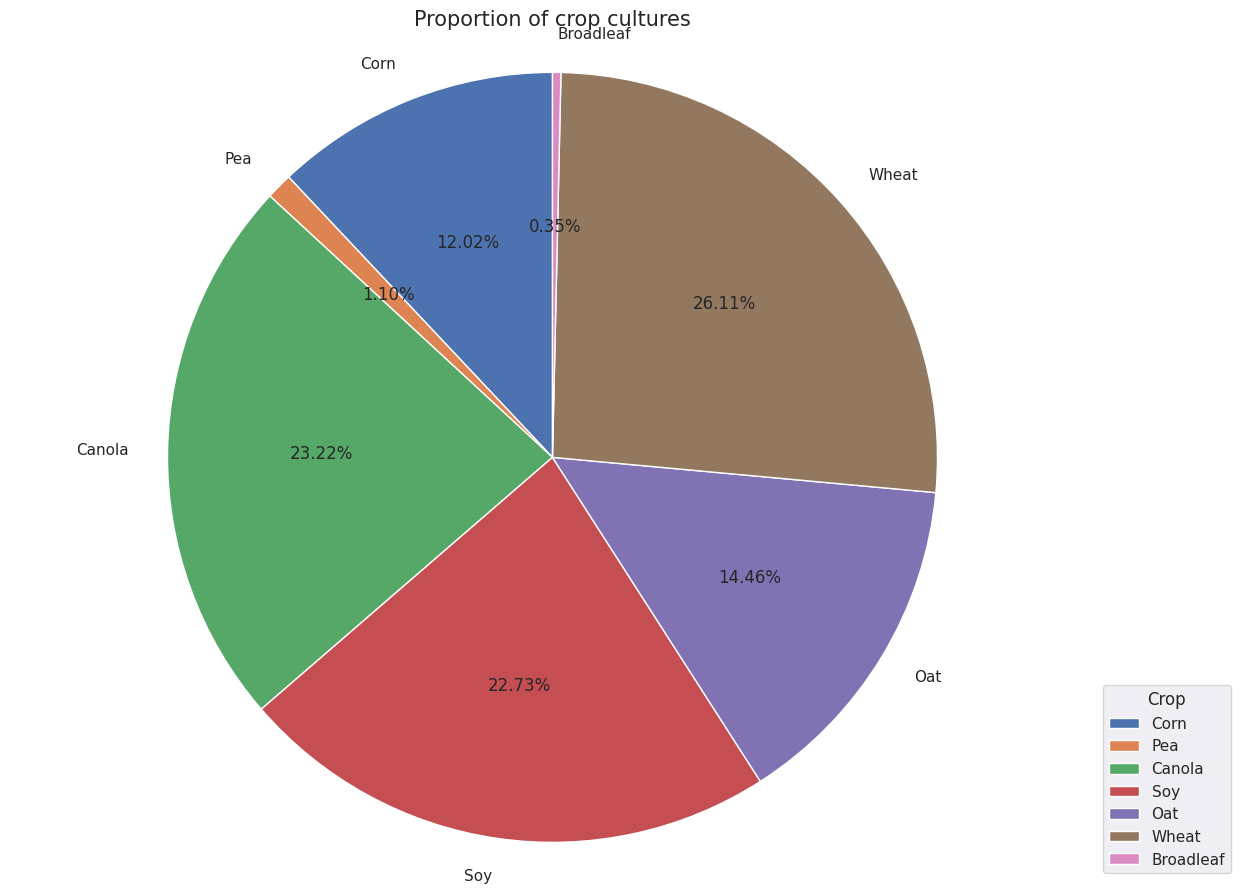

In [ ]:
size = raw_data.label.value_counts().sort_index()
labels = 'Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'
fig, ax = plt.subplots(figsize = (14, 11))
ax.pie(size, explode = None, labels=labels, autopct='%2.2f%%', startangle=90)
ax.axis('equal')
plt.title('Proportion of crop cultures', size=15)
ax.legend(labels, bbox_to_anchor = (1, 0), loc = 'lower left', title = 'Crop')
plt.show()

Given, wheat makes up 26.11% of all crops, followed by canola (23.22%) and soy (22.73%). According to the baseline model, wheat will make up 26.11% of all crops. 

The business is more interested in identifying these crops than it is in accurately predicting the crops that are Wheat, Canola, and Soy, thus we need to make sure that the chosen model does not predict the others with lesser accuracy, such as Breadleaf 0.35%, Pea 1.10%.

# 4. Check for Outliers

In [ ]:
raw_data.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,0.142869,0.127552,6.215130e-03,0.034536,0.029085,0.024727,0.036791,0.029027,0.006083,0.021235,-17.032833,-26.717638,-18.747312,-21.423108,-16.771375,-21.235700,1.714480,-9.684806,-7.970327,-0.187407,4.651733,4.464326,0.556719,0.062170,0.381110,0.202417,0.586375,0.211207,-2.084016,-1.258692,-1.975972,-2.266397,-1.883872,-1.478220,0.033008,0.014529,0.003190,0.719414,0.660229,41.743319,

There is no much difference between the max and the mean of each features. Therefore, we can say there are no outliers present. We will go deeper into the distributions.

## 4.1 Outlier Detection and Treatment

### IQR (Inter Quantile Range) for Outlier Detection

In [ ]:
def detect_outliers(df, remove_outlier = True):
    
    """
    Function to detect the presence of Outliers in a column
    when remove_outler = False or to remove 
    Outliers when remove_outler = True
    
    Args:
        df (Dataframe) : dataframe of the data
        col (string) : column name of the data
    
    Returns:
        float : detected outliers
    """
    
    if remove_outlier:
        # 1st quantile is 0.1%
        Q1 = df.quantile(0.001)
        # 3rd quantile is 99.9%
        Q3 = df.quantile(0.999)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR

        return df.loc[~((df < lower_limit) | (df > upper_limit)).any(axis=1)]
    
    else:
        print('Shape before outlier removal -> ',df.shape)
        Q1 = df.quantile(0.001)
        Q3 = df.quantile(0.999)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        
        return df.loc[((df < lower_limit) | (df > upper_limit)).any(axis=1)]

In [ ]:
detect_outliers(raw_data, remove_outlier = False)

Shape before outlier removal ->  (325834, 175)


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.55900,-21.4070,-11.40400,-15.24800,-11.92300,-15.29100,-2.15480,-7.8474,-10.0020,0.042390,3.32530,3.36770,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.195680,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.196170,0.25967,0.120130,0.054561,0.162260,-11.92300,-12.82300,-21.4070,0.17610,0.16811,0.002613,0.066037,0.025145,0.028249,0.056669,0.037053,0.005979,0.024823,-12.5640,-23.436,-13.8580,-18.2090,-11.55600,-17.9340,1.294400,-10.8730,-9.5783,-0.27493,6.6524,6.3775,0.54823,0.044843,0.40693,0.14944,0.69136,0.15920,-1.87270,-0.78500,-1.98950,-2.99650,-1.77380,-1.73260,0.071334,0.025359,0.004391,0.66368,0.70484,42.797,0.46779,0.195890,0.23705,0.099269,0.061549,0.173740,-11.55600,-15.74000,-23.436,0.18156,0.11893,0.003407,0.057758,0.019568,0.017713,0.058723,0.019425,0.004282,0.016069,0.009,0.057,0.048,0.165,0.369,0.76978,7.6875,1.18750,0.50488,0.61842,0.52508,0.085714,0.73239,0.50279,0.38202,2.2364,-0.48649,17.28,0.54930,0.128250,7.38,3.4375,22.667,8.2222,0.27512,13.4440,3.0000,2.1972,0.11111,0.452700,7.7778,17.28400,0.27566,24.55600,3.66670,2.04320,0.13580,0.650770,6711,6143,4570,5064,8212,0.284930,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.40,92560.0,1.10810,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.726020,5.3333,6.00000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
312,1,-15.89900,-22.5160,-12.33900,-16.32000,-13.39000,-16.87700,-3.56030,-6.6169,-10.1770,0.556740,2.93030,3.48710,0.28670,0.062479,0.65082,0.26020,0.51091,0.22889,-0.58056,-0.87370,-0.65135,-0.58037,-0.197190,-0.64533,0.067394,0.018456,0.003820,0.61390,0.65702,44.934,0.40334,0.210560,0.25368,0.132430,0.056685,0.170410,-13.39000,-14.17300,-22.5160,0.15022,0.14522,0.007463,0.049801,0.016636,0.023094,0.042293,0.027533,0.005979,0.017482,-14.1670,-23.846,-13.6570,-19.1680,-12.16300,-18.9850,-0.509960,-9.6788,-10.1890,-0.18364,7.0050,6.8213,0.44797,0.048236,0.50379,0.14163,0.71063,0.14774,-1.78130,-0.68171,-1.74150,-2.42040,-1.64870,-1.96010,0.061547,0.020024,0.003942,0.65399,0.67106,48.630,0.43886,0.215120,0.23220,0.113820,0.064043,0.184380,-12.16300,-16.85700,-23.846,0.17016,0.10946,0.002061,0.049882,0.015858,0.016585,0.050078,0.016117,0.004282,0.015674,0.002,0.045,0.037,0.120,0.285,0.77019,7.7027,1.21620,0.41555,0.59664,0.45255,0.097561,0.72727,0.41885,0.40741,2.3750,-0.45455,14.10,0.52866,0.103050,5.30,3.2432,19.667,4.8889,0.56937,8.7778,1.8889,1.5811,0.25926,-0.080582,6.7778,14.39500,0.56110,22.22200,2.88890,1.42710,0.28395,-0.258850,6426,5812,4052,4725,7921,0.323140,1.9548,1.4344,-0.60601,0.65038,0.48470,0.17843,0.153570,0.65626,0.25273,1.6764,0.25273,298510.0,0.076678,2779.50,110780.0,1.16610,49.000,1.33330,0.63333,2.33330,1.00000,1.3108,0.28395,-0.612370,4.2222,5.95060,0.55172,7.77780,1.77780,1.67700,0.20988,0.53940
2229,1,-15.11200,-22.0090,-12.68900,-16.81100,-13.26100,-16.39800,-2.42360,-6.8971,-9.3207,-0.413850,3.55050,3.13670,0.33880,0.069221,0.59198,0.22910,0.51889,0.25201,-0.72995,-0.90324,-0.68642,-0.72736,-0.229990,-0.77446,0.064965,0.021686,0.004307,0.66140,0.66863,44.486,0.44223,0.219170,0.22640,0.112200,0.066290,0.189390,-13.26100,-14.26400,-22.00

In [ ]:
data = detect_outliers(raw_data)

In [ ]:
data.shape

(325469, 175)

# 5. Check for Missing Values

In [ ]:
data.isnull().sum()

label    0
f1       0
f2       0
f3       0
f4       0
        ..
f170     0
f171     0
f172     0
f173     0
f174     0
Length: 175, dtype: int64

# 6. Correlation

The correlation between each feature and the dependent variable, as well as the correlation among features (intercorrelation), provide elements to tackle potential undesired collinearity.

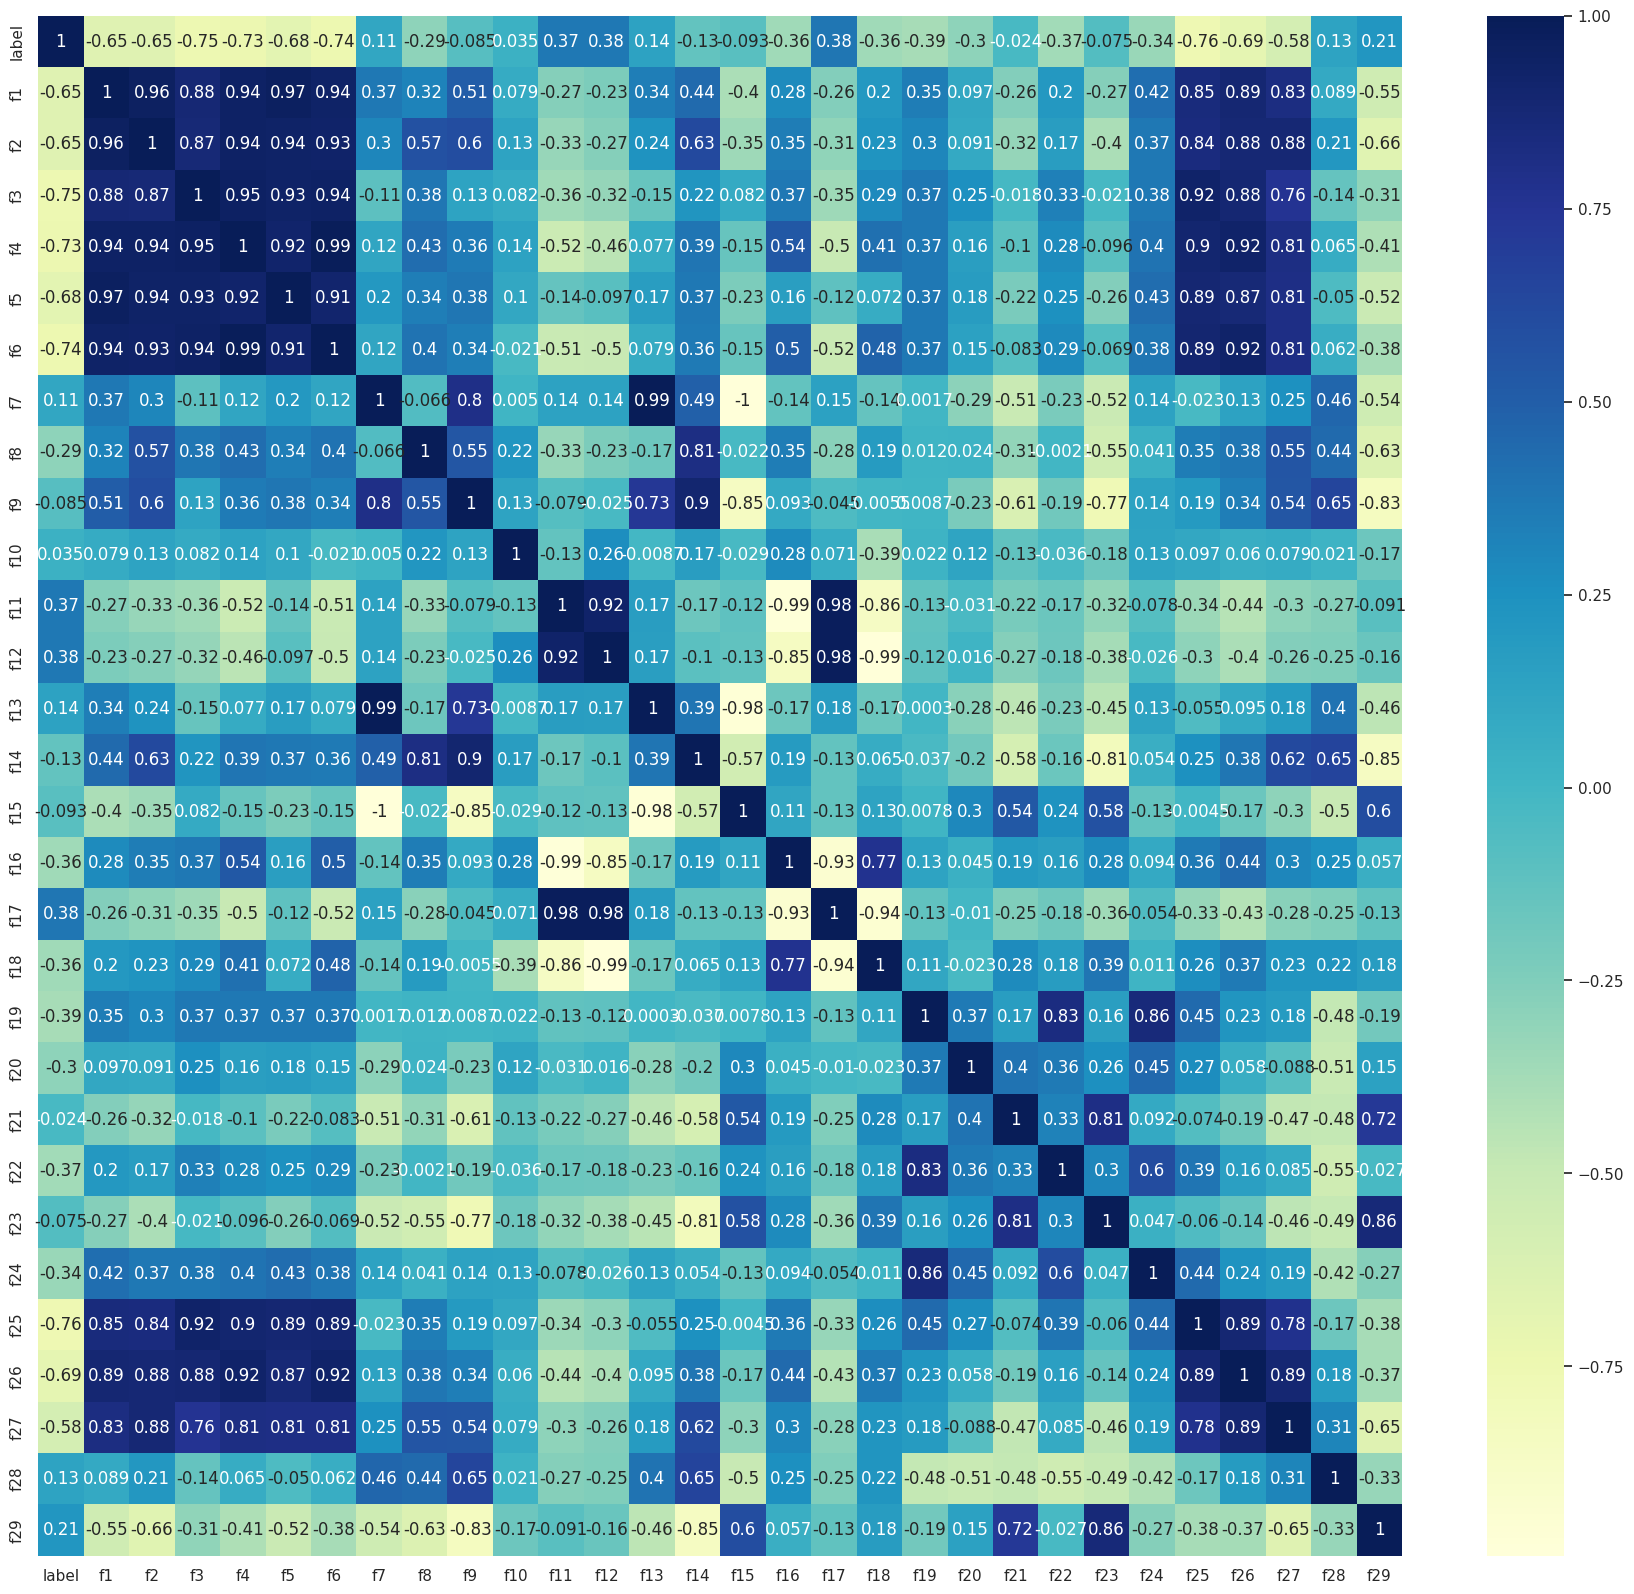

In [ ]:
plt.figure(figsize=(22, 20))
corr_matrix = data.corr()
# Display the first 50 columns
sns.heatmap(corr_matrix.iloc[:30, :30], annot = True, cmap="YlGnBu")
plt.show()

In [ ]:
corr_matrix.label.sort_values(ascending=False)

label    1.000000
f159     0.508915
f78      0.433738
f111     0.391795
f17      0.384036
           ...   
f50     -0.802042
f88     -0.808972
f51     -0.808972
f86     -0.809995
f54     -0.809995
Name: label, Length: 175, dtype: float64

In [ ]:
print(max([x for x in corr_matrix.label if isinstance(x, (int, float)) and x != 1]))

0.5089148089395014


In [ ]:
corr_matrix.label.min()

-0.8099949845258677

## 6.1 Feature Selection based on the correlation matrix

In [ ]:
def correlated_feature_extraction(threshold: int = 0.01):
  
  """ Method that selects features based on the most correlated features with the label classes
  """
  corr_matrix_threshold = corr_matrix[abs(corr_matrix) > 0.01]

  # create a set of all feature labels
  feature_labels = set(corr_matrix.columns)

  # create an empty set to store the most correlated features
  most_correlated_features = set()

  # loop over all features
  for feature_label in feature_labels:
      # get the correlated values of the current feature with all other features
      correlated_features = set(corr_matrix_threshold[feature_label].dropna().index)
      # remove the current feature from the set of correlated features
      correlated_features.remove(feature_label)
      # check if the current feature has at least one highly correlated feature
      if len(correlated_features) > 0:
          # add the most highly correlated feature to the set of most correlated features
          most_correlated_feature = max(correlated_features, key=lambda x: abs(corr_matrix.loc[x, feature_label]))
          most_correlated_features.add(most_correlated_feature)


  print(most_correlated_features)
  selected_features = list(most_correlated_features)
  selected_features.append('label')

  print('Total number of features before correlation: ',data.shape[1])
  print('Most correlated features: ', len(most_correlated_features))

  return data[selected_features]

In [ ]:
data_cleaned = correlated_feature_extraction()

{'f122', 'f158', 'f62', 'f135', 'f85', 'f113', 'f39', 'f93', 'f12', 'f31', 'f34', 'f15', 'f101', 'f80', 'f79', 'f11', 'f54', 'f140', 'f146', 'f157', 'f46', 'f88', 'f94', 'f132', 'f126', 'f41', 'f108', 'f51', 'f64', 'f172', 'f86', 'f66', 'f134', 'f2', 'f162', 'f131', 'f19', 'f109', 'f155', 'f5', 'f165', 'f61', 'f33', 'f6', 'f114', 'f156', 'f70', 'f59', 'f78', 'f164', 'f84', 'f103', 'f35', 'f37', 'f49', 'f92', 'f169', 'f144', 'f91', 'f10', 'f171', 'f141', 'f44', 'f95', 'f133', 'f28', 'f105', 'f138', 'f68', 'f100', 'f16', 'f29', 'f81', 'f96', 'f7', 'f120', 'f149', 'f43', 'f53', 'f30', 'f60', 'f45', 'f36', 'f151', 'f48', 'f42', 'f127', 'f139', 'f147', 'f76', 'f125', 'f87', 'f72', 'f142', 'f148', 'f63', 'f65', 'f107', 'f159', 'f102', 'f104', 'f124', 'f129', 'f167', 'f67', 'f161', 'f14', 'f83', 'f18', 'f56', 'f32', 'f24', 'f121', 'f82', 'f47', 'f23', 'f117', 'f17', 'f38', 'f173', 'f111', 'f163', 'f153'}
Total number of features before correlation:  124
Most correlated features:  123


In [ ]:
data_cleaned.head()

,f122,f158,f62,f135,f85,f113,f39,f93,f12,f31,f34,f15,f101,f80,f79,f11,f54,f140,f146,f157,f46,f88,f94,f132,f126,f41,f108,f51,f64,f172,f86,f66,f134,f2,f162,f131,f19,f109,f155,f5,f165,f61,f33,f6,f114,f156,f70,f59,f78,f164,f84,f103,f35,f37,f49,f92,f169,f144,f91,f10,f171,f141,f44,f95,f133,f28,f105,f138,f68,f100,f16,f29,f81,f96,f7,f120,f149,f43,f53,f30,f60,f45,f36,f151,f48,f42,f127,f139,f147,f76,f125,f87,f72,f142,f148,f63,f65,f107,f159,f102,f104,f124,f129,f167,f67,f161,f14,f83,f18,f56,f32,f24,f121,f82,f47,f23,f117,f17,f38,f173,f111,f163,f153,label
1,0.46914,1.1456,0.54939,0.30864,0.16287,0.47583,-20.335,0.023410,3.2644,0.40738,0.12886,0.59652,0.037,0.46579,42.706,3.0360,-10.5000,3777,0.92501,100280.0,0.066831,-22.730,0.019954,0.55556,1.5230,0.18203,0.59780,-22.730,0.40866,0.84869,-10.5000,0.70110,1.2730,-20.335,1.33330,0.72222,-0.57229,0.45889,0.067854,-11.096,0.33333,6.5948,0.26758,-14.361,2.8155,2338.4,-1.9783,-0.239200,0.71519,1.2149,0.057024,0.290,0.052298,-11.096,0.027797,0.071813,0.83333,1.5420,0.002202,0.22842,0.33333,8214,0.027181,0.072635,0.55556,0.60356,7.8378,5084,-1.9547,0.044,0.25249,0.67496,0.18549,0.023165,-2.4039,2.7838,0.235370,0.078576,-17.334,44.992,6.8340,0.034402,0.15826,0.37003,0.005979,0.006412,0.23457,3297,0.64071,0.005176,0.88889,-14.859,-1.8280,0.42716,0.21322,0.041949,0.14534,0.42041,49.778,0.103,0.77370,1.33330,3.8889,2.1111,0.15357,0.46667,0.060525,0.099319,0.23955,1.2853,0.19618,-0.55448,18.556,0.24940,0.043155,-0.18825,0.47143,0.50796,-11.805,0.50617,0.73653,1.11110,0.37003,1
2,0.66667,1.2651,0.55811,0.30864,0.15439,0.47160,-19.902,0.026262,3.2185,0.39919,0.13211,0.59338,0.046,0.46000,42.195,2.7687,-9.9970,3837,1.03530,128320.0,0.072656,-22.566,0.021257,0.66667,1.6770,0.19066,0.53213,-22.566,0.40261,1.27300,-9.9970,0.70963,1.2730,-19.902,0.77778,0.66667,-0.53347,0.44787,0.117030,-10.829,0.25926,6.8757,0.28105,-14.048,2.7850,3321.3,-2.1281,-0.030712,0.72068,1.3689,0.053338,0.298,0.048473,-10.829,0.029540,0.083737,0.68889,1.6601,0.000408,0.44978,0.66667,8588,0.086472,0.084201,0.66667,0.58683,6.4783,5035,-2.3606,0.046,0.26362,0.68024,0.17829,0.025911,-2.3566,2.3261,0.260810,0.027212,-16.903,45.466,6.9065,0.039597,0.14878,0.38237,0.005979,0.010325,0.20988,3033,0.71699,0.005443,1.11110,-14.509,-2.1057,0.47801,0.24814,0.039276,0.14467,0.40217,49.444,0.107,0.73256,2.44440,3.8889,2.2222,0.14570,0.61111,0.061731,0.101030,0.23768,1.4183,0.18764,-0.48642,19.000,0.26068,0.047041,-0.17804,0.39869,0.49870,-11.377,0.30864,0.73256,0.77778,0.38237,1
3,1.55560,1.0764,0.54798,0.16049,0.14955,0.40594,-19.529,0.028162,2.9580,0.38976,0.13738,0.60457,0.074,0.44972,42.803,2.2942,-9.6992,4534,0.65772,80640.0,0.075066,-22.520,0.021817,2.00000,1.5230,0.19425,0.37198,-22.520,0.41419,1.14910,-9.6992,0.72419,1.8892,-19.529,0.77778,0.53333,-0.50405,0.36713,0.036817,-11.056,0.16049,7.2654,0.28492,-14.014,2.3667,1748.1,-2.2977,0.124570,0.71891,1.8892,0.050939,0.284,0.047480,-11.056,0.029684,0.092551,0.83333,1.3640,0.000934,0.66378,0.33333,7691,0.091109,0.093280,1.11110,0.57769,3.8378,5745,-2.6845,0.071,0.28135,0.67468,0.17584,0.027699,-2.6611,1.6216,0.144830,0.025256,-16.840,46.654,7.1408,0.042959,0.14701,0.25824,0.005979,0.014031,0.23457,4212,0.43840,0.005533,1.33330,-14.532,-2.3477,0.29228,0.15396,0.037823,0.13988,0.32957,50.667,0.120,0.58659,2.00000,6.2222,4.1111,0.13593,0.61111,0.067825,0.105250,0.24148,1.2156,0.18793,-0.43576,17.333,0.26918,0.048926,-0.17507,0.23711,0.47717,-11.263,0.38272,0.60000,0.77778,0.25824,1
4,0.44444,1.0435,0.55209,0.20988,0.14325,0.33671,-19.278,0.030130,3.0070,0.38505,0.14108,0.61351,0.068,0.44962,42.535,2.1756,-9.3839,4627,0.52776,69540.0,0.076086,-22.387,0.022753,1.33330,1.2730,0.19809,0.40053,-22.387,0.41148,1.58110,-9.3839,0.72737,1.5811,-19.278,1.66670,0.60000,-0.50314,0.35337,0.021300,-10.932,0.18519,7.3059,0.27955,-13.939,2.0153,1365.4,-2.0977,0.067196,0.72670,1.7351,0.048530,0.264,0.048950,-10.932,0.030782,0.099970,0.68889,1.3268,0.001512,0.83143,0.66667,7072,0.094832,0.100950,0.88889,0.57937,3.

In [ ]:
# We assign the dependent feature to a variable y
y = data_cleaned.label
# We assign the independent features to a variable x
x = data_cleaned
data_cleaned = data_cleaned.drop(['label'], axis = 1)

# 7. Split and Scale the Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(218064, 124) (107405, 124) (218064,) (107405,)
